In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [6]:
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/fig2/G4-CTCF-dots/intersect-all-NT-CTCF-NO-G4-centered-RAD21 ./
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/draft8-after-NSMB/CTCF-peaks-with-RAD21 ./

In [7]:
# consider switching to *ALL* CTCF with RAD21 (regardless of TSS) for the rescaled analysis ...
# here is a location:
# /nl/umw_job_dekker/users/av90w/projects/for-paper/draft8-after-NSMB/CTCF-peaks-with-RAD21

In [8]:
ctcf_df = bioframe.read_table(
    "CTCF-peaks-with-RAD21",
    names=["chrom","start","end"],
    usecols=[0,1,2]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df["type"] = "ctcf"
ctcf_df = ctcf_df.reset_index(drop=True)

#### Annotate our CTCF ChipSeq peaks with the motifs ...

In [9]:
### CTCF motif: http://jaspar.genereg.net/matrix/MA0139.1/
jaspar_url = 'http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2022/hg19/'
jaspar_motif_file = 'MA0139.1.tsv.gz'
ctcf_motifs = bioframe.read_table(
                jaspar_url+jaspar_motif_file,
                skiprows=1,
                names=["chrom", "start", "end","name","score", "pval", "strand"]
)
ctcf_motifs = ctcf_motifs.sort_values(["chrom","start"])
ctcf_motifs = ctcf_motifs[ ctcf_motifs["chrom"].isin(autosomal_chroms) ]
ctcf_motifs = ctcf_motifs.reset_index(drop=True)

# beforehand we used FIMO to find motifs in the hg19 - ourselves
# it seems to match the published one - OK - so we'll use the published one:
# # here is very-very liberal list of CTCF calls in hg19, based on "MA0139.1.meme" from JASPAR
# # P-val cutoff was 1e-4 - let's see how it looks here ...
# !scp ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/CTCF_motif/CTCF.hist.txt ./CTCF.MA0139.1.txt

In [10]:
ctcf_motif_annotated = bioframe.overlap(
    ctcf_df,
    ctcf_motifs,
    how="inner",
    suffixes=('','_')
)
# for a peak with several motifs, assign the "strongest" one:
# NOTE pval here is actually -1 * log10(actual_pval) * 100 , i.e. 10^(-13) --> 1_300
max_idx = ctcf_motif_annotated.groupby(["chrom","start","end"])["pval_"].idxmax()

_cols = ["chrom",
        "start",
        "end",
        "type",
        "strand_"]
_rename_cols = {"strand_":"strand"}

ctcf_motif_annotated = ctcf_motif_annotated \
                        .loc[max_idx,_cols] \
                        .rename(_rename_cols,axis=1) \
                        .reset_index(drop=True)
ctcf_motif_annotated.head()
print(f"there are {len(ctcf_df) - len(ctcf_motif_annotated)} CTCF-CHipSeq-peaks-with-RAD21 that do not have a MOTIF associated with them out of {len(ctcf_df)}")

there are 1222 CTCF-CHipSeq-peaks-with-RAD21 that do not have a MOTIF associated with them out of 12033


In [11]:
# merge full list of ctcf_df with the annotated subset - to get them all - "-","+" and None-s
ctcf_motif_annotated = pd.merge(ctcf_df, ctcf_motif_annotated, how="left", on=["chrom","start","end","type"])

#### read a list of active TSSs ...

In [12]:
# this is how one can read a DataFrame into memory:
# bf is short for bioframe here ...
feature_of_interest = "ActiveTSS-NO-CTCF-8849-1bp.bed"
tss_df = bioframe.read_table(
    feature_of_interest,
    names=["chrom","start","end","strand"]
)
tss_df = tss_df.sort_values(["chrom","start"]) # sort ...
tss_df = tss_df[tss_df["chrom"].isin(autosomal_chroms)] # filter chroms
tss_df["type"] = "tss"
tss_df = tss_df.reset_index(drop=True)

In [13]:
# HAP1-Enhancers-K27minusTSSminusCTCFoverlapDNase_10443.bed

# this is how one can read a DataFrame into memory:
# bf is short for bioframe here ...
feature_of_interest = "HAP1-Enhancers-K27minusTSSminusCTCFoverlapDNase_10443.bed"
enhance_df = bioframe.read_table(
    feature_of_interest,
    names=["chrom","start","end"]
)
enhance_df = enhance_df.sort_values(["chrom","start"]) # sort ...
enhance_df = enhance_df[enhance_df["chrom"].isin(autosomal_chroms)] # filter chroms
enhance_df["type"] = "enhancer"
enhance_df = enhance_df.reset_index(drop=True)

```python
# just an example-prototype on how we can do pairwise combinations dissected by orientation/type/etc
# also in this case we are combining 2 lists of intervals - to get to pairwise interactions between the two
# let's assume that we have 2 dataframes - df and df1 :
a = df.head().copy()
b = df1.head().copy()
a["type"] = "a"
b["type"] = "b"

xxx = pd.concat([a,b]).reset_index(drop=True)
print(xxx)

yyy = bioframe.pair_by_distance(xxx,min_sep=0,max_sep=100000000)
# select only interactions between different types ...
print(yyy[yyy["type_1"] != yyy["type_2"]].reset_index(drop=True))
```

### Create a list of all pairwise interactions between enhancers and promoters ...

In [14]:
# enhance_df
# ctcf_df
# tss_df
dfs_concat = pd.concat([enhance_df,tss_df]).reset_index(drop=True)
bedpe = bioframe.pair_by_distance(dfs_concat, min_sep=50_000, max_sep=500_000, suffixes=('1','2'))
bedpe = bedpe[ (bedpe["type1"] != bedpe["type2"]) ].reset_index(drop=True)
print(bedpe.head(3))

  chrom1  start1    end1     type1 strand1 chrom2  start2    end2     type2  \
0  chr18  158556  158557       tss       +  chr18  634756  635309  enhancer   
1  chr18  191023  191938  enhancer     NaN  chr18  657652  657653       tss   
2  chr18  191023  191938  enhancer     NaN  chr18  658290  658291       tss   

  strand2  
0     NaN  
1       +  
2       -  


In [15]:
bedpe_ctcf_overlap = bioframe.overlap(
    bedpe,
    ctcf_motif_annotated,
    how='left',
    suffixes=('', '_'),
    cols1=["chrom1","end1","start2"],
)
bedpe_ctcf_overlap.head()

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,type2,strand2,chrom_,start_,end_,type_,strand_
0,chr18,158556.0,158557,tss,+,chr18,634756,635309.0,enhancer,NaN,chr18,596929,597333,ctcf,+
1,chr18,191023.0,191938,enhancer,NaN,chr18,657652,657653.0,tss,+,chr18,596929,597333,ctcf,+
2,chr18,191023.0,191938,enhancer,NaN,chr18,658290,658291.0,tss,-,chr18,596929,597333,ctcf,+
3,chr18,268046.0,268047,tss,-,chr18,634756,635309.0,enhancer,NaN,chr18,596929,597333,ctcf,+
4,chr18,268046.0,268047,tss,-,chr18,740677,741086.0,enhancer,NaN,chr18,596929,597333,ctcf,+


Text(0.5, 0, 'genomic separation between E and P, bp')

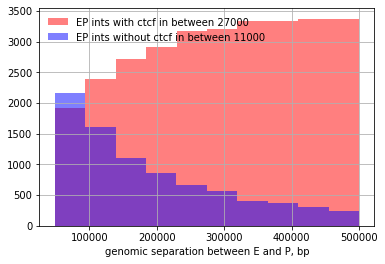

In [16]:
# some intermediate check - to see how often does a CTCF "hide" between E and P depending on the distance between them
_1 = bedpe_ctcf_overlap[~bedpe_ctcf_overlap["chrom_"].isna()] \
    .drop_duplicates(subset=["chrom1","start1","end1","chrom2","start2","end2"]) \
    .reset_index(drop=True)
(_1["start2"] - _1["end1"]).hist(alpha=0.5,color="red",label="EP ints with ctcf in between 27000")

_ = bedpe_ctcf_overlap[bedpe_ctcf_overlap["chrom_"].isna()]
(_["start2"] - _["end1"]).hist(alpha=0.5,color="blue",label="EP ints without ctcf in between 11000")
plt.legend(frameon=False)
plt.xlabel("genomic separation between E and P, bp")

In [17]:
# previous Anne-Laure's code - didn't take "undetermined" CTCFs into account - we might get back to it...
# #
# cols = ['chrom1','start1','end1','type1','strand1','chrom2','start2','end2','type2','strand2','type','strandc_']
# #first drop *ALL* duplicates, this would keep 1 row per EP if there were CTCFs of same orientation, and 2 rows if they were +/-
# bedpe_ctcf_overlap = bedpe_ctcf_overlap[cols].drop_duplicates().reset_index(drop=True).rename({"type": "between_status", "strandc_":"strandc"},axis=1)
# #drop duplicates (on subset of EP-rows) to remove EP-s that have >1 CTCF of different orientation
# bedpe_ctcf_overlap = bedpe_ctcf_overlap.drop_duplicates(subset=['chrom1', 'start1', 'end1', 'type1', 'strand1', 'chrom2', 'start2','end2', 'type2', 'strand2','between_status'], keep=False).reset_index(drop=True)

In [18]:
# repeat 1st step from Anne-Laure's analysis - to keep only one CTCF of a given orientation per EP:
subset1 = ['chrom1','start1','end1','type1','strand1','chrom2','start2','end2','type2','strand2','type_','strand_']
bedpe_ctcf_overlap = bedpe_ctcf_overlap \
                    .drop_duplicates(subset=subset1) \
                    .reset_index(drop=True)

(array([    0., 19749., 13322.,  4937.,     0.]),
 array([0, 1, 2, 3, 4, 5]),
 <BarContainer object of 5 artists>)

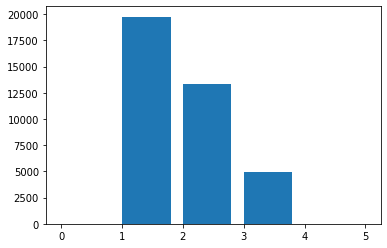

In [19]:
# check the distribution of group sizes
plt.hist(bedpe_ctcf_overlap.groupby(['chrom1','start1','chrom2','start2']).size(),bins=[0,1,2,3,4,5],width=0.8)

#### Sort out all types of EP according to the status of CTCFs in-between ...

In [20]:
def assign_status(df):
    # df[['type_','strand_']]
    if len(df)==3:
        return "all"
    elif (len(df)==2)and(df["strand_"].isnull().any()):
        _orient = df.dropna(subset=["strand_"])["strand_"].iloc[0]
        return f"almost{_orient}"
    elif len(df)==2:
        return "mix+-"
    elif df["type_"].iloc[0] == "ctcf":
        return df["strand_"].iloc[0]
    else:
        return "empty"

res = bedpe_ctcf_overlap.groupby(['chrom1','start1','chrom2','start2']).apply(assign_status)
res.name="status"
res.value_counts(dropna=False)

mix+-      10920
empty       8296
-           5283
+           5221
all         4937
almost-     1216
almost+     1186
NaN          949
Name: status, dtype: int64

In [21]:
# Now, merge these EPs (formerly grouped by CTCF) with the original EP dataframe to get full info ...
cols_output = ['chrom1','start1','end1','type1','strand1','chrom2','start2','end2','type2','strand2']
output_df = pd.merge(
    res.reset_index(),
    bedpe_ctcf_overlap[cols_output],
    how="left",
    on=['chrom1','start1','chrom2','start2']
).drop_duplicates()[cols_output+["status"]]
# sample output
output_df.head()

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,type2,strand2,status
0,chr1,762901.0,762902,tss,-,chr1,816241,817150.0,enhancer,NaN,+
1,chr1,762901.0,762902,tss,-,chr1,969279,969493.0,enhancer,NaN,all
4,chr1,762901.0,762902,tss,-,chr1,1014914,1015649.0,enhancer,NaN,all
7,chr1,762970.0,762971,tss,+,chr1,816241,817150.0,enhancer,NaN,+
8,chr1,762970.0,762971,tss,+,chr1,969279,969493.0,enhancer,NaN,all


In [22]:
fname = "EP_50-500kb_with_detailed_CTCF_status_stricter.bedpe"
output_df.to_csv(fname, sep="\t", index=False)
! scp {fname} ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp {fname} shadow:/data/venevs/ALV-repo/

EP_50-500kb_with_detailed_CTCF_status_stricte 100% 2681KB   3.2MB/s   00:00    
EP_50-500kb_with_detailed_CTCF_status_stricte 100% 2681KB  10.6MB/s   00:00    


In [177]:
# # cleanup output of the 'bedpe_ctcf_overlap':
# _cols = ['chrom1', 'start1', 'end1', 'type1', 'strand1', 'chrom2', 'start2','end2', 'type2', 'strand2','type_']
# bedpe_ctcf_overlap = bedpe_ctcf_overlap[_cols] \
#     .drop_duplicates() \
#     .reset_index(drop=True) \
#     .rename({"type_": "between_status"},axis=1)

In [178]:
# bedpe_ctcf_overlap.to_csv("EP_50-500kb_with_CTCF_status.bedpe",sep="\t",index=False)
# ! scp EP_50-500kb_with_CTCF_status.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### Try to deal with the neighbours analysis ...

#### strategy to address the neighbours ...

1. for every CTCF (+/-) check "closest" TSS (+/-):
     - first "upstream" - independently
     - second "downstream" - indep.
     - Note that this way >1 CTCF can "interact" with the same TSS
2. For both of these lists - groupby TSS and pick nearest CTCF in a per TSS manner
     - This way we ensure there is nothing between a given TSS and CTCF
     - for a given TSS we also keep track of 2 closest CTCFs up- and down-stream
3. Concatenate resulting two lists _up_ and _down_ -> this is the final list of CTCF-TSS interactions

In [36]:
# for every CTCF find nearest TSS downstream
_down = bioframe.closest(
    ctcf_motif_annotated,
    tss_df,
    k=1,
    ignore_overlaps=True,
    ignore_upstream=True,
    ignore_downstream=False,
    suffixes=('1', '2'),
)
# groupby on TSSs - to select the closest CTCF
# and make sure we get CTCF-TSS interactions with nothing in between
# display(_down)
_down_tss = _down.loc[_down.groupby(["chrom2","start2","end2"])["distance"].idxmin()]
display(_down_tss)
(_down_tss["start2"]>_down_tss["end1"]).all()

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance
0,chr1,10151,10508,ctcf,-,chr1,29369,29370,-,tss,18861
3,chr1,873599,873857,ctcf,-,chr1,894635,894636,-,tss,20778
5,chr1,968050,968716,ctcf,+,chr1,1004716,1004717,-,tss,36000
6,chr1,1057249,1057885,ctcf,+,chr1,1167380,1167381,-,tss,109495
8,chr1,1227273,1227656,ctcf,-,chr1,1243959,1243960,+,tss,16303
...,...,...,...,...,...,...,...,...,...,...,...
8723,chr9,139565964,139566655,ctcf,-,chr9,139581908,139581909,-,tss,15253
8724,chr9,139588664,139589215,ctcf,-,chr9,139607023,139607024,+,tss,17808
8725,chr9,139929536,139930441,ctcf,+,chr9,139948512,139948513,-,tss,18071
8726,chr9,140121819,140122389,ctcf,-,chr9,140149778,140149779,+,tss,27389


True

In [37]:
# for every CTCF find nearest TSS downstream
_up = bioframe.closest(
    ctcf_motif_annotated,
    tss_df,
    k=1,
    ignore_overlaps=True,
    ignore_upstream=False,
    ignore_downstream=True,
    suffixes=('1', '2'),
)
# groupby on TSSs - to select the closest CTCF
# and make sure we get CTCF-TSS interactions with nothing in between
# display(_up)
_up_tss = _up.loc[_up.groupby(["chrom2","start2","end2"])["distance"].idxmin()]
display(_up_tss)
(_up_tss["start2"]<_up_tss["end1"]).all()

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance
0,chr1,804937,805691,ctcf,+,chr1,762970,762971,+,tss,41966
3,chr1,919017,919979,ctcf,+,chr1,901861,901862,+,tss,17155
5,chr1,1057249,1057885,ctcf,+,chr1,1051468,1051469,-,tss,5780
6,chr1,1225501,1225951,ctcf,-,chr1,1209233,1209234,-,tss,16267
8,chr1,1590639,1591017,ctcf,-,chr1,1550794,1550795,+,tss,39844
...,...,...,...,...,...,...,...,...,...,...,...
8725,chr9,139588664,139589215,ctcf,-,chr9,139581908,139581909,-,tss,6755
8726,chr9,139929536,139930441,ctcf,+,chr9,139886873,139886874,+,tss,42662
8727,chr9,140121819,140122389,ctcf,-,chr9,140115774,140115775,-,tss,6044
8728,chr9,140188936,140190350,ctcf,+,chr9,140149778,140149779,+,tss,39157


True

there should be 0 duplicated interactions in our list - we got 0
there are 1454 TSS that show up >1 in the interactions list (they have >1 nearest CTCF)
there are 1413 CTCF that show up >1 in the interactions list
there are 5518 TSS we have in the interaction list, out of 8849 total (3331 unused ...)
there are 0 super short range CTCF-TSS interactions in our final list


<AxesSubplot:ylabel='Frequency'>

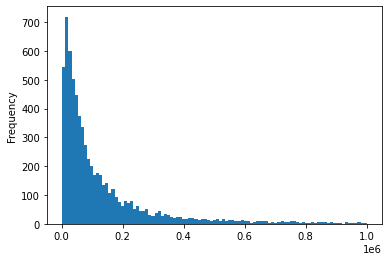

In [38]:
#####
# Concatenating up and down CTCF-TSS as is ! without flipping - just to produce some
# important informational messages ...
# to be redone for output and other checks ...
#####
# concat upp and down CTCF-TSS interactions:
_ctcf_tss_df = pd.concat([_up_tss,_down_tss]).reset_index(drop=True)
# are there any duplicated interactions for whatever reason - should be none ...
dups_ints = _ctcf_tss_df.duplicated(subset=["chrom1","start1","end1","chrom2","start2","end2"]).sum()
print(f"there should be 0 duplicated interactions in our list - we got {dups_ints}")
# how many TSS show up twice in the list ?
dups_tss = _ctcf_tss_df.duplicated(subset=["chrom2","start2","end2"]).sum()
print(f"there are {dups_tss} TSS that show up >1 in the interactions list (they have >1 nearest CTCF)")
# how many CTCF show up twice in the list ?
dups_ctcf = _ctcf_tss_df.duplicated(subset=["chrom1","start1","end1"]).sum()
print(f"there are {dups_ctcf} CTCF that show up >1 in the interactions list")
# how many unique TSS are we dealing with ?
uniq_tss = len(_ctcf_tss_df.drop_duplicates(subset=["chrom2","start2","end2"]))
print(f"there are {uniq_tss} TSS we have in the interaction list, out of {len(tss_df)} total ({len(tss_df)-uniq_tss} unused ...)")
# how many of the interactions are closer than 2kb ? - should be none! - by construction of the input CTCF and TSS lists...
short_range_ints = (_ctcf_tss_df["distance"]<2_000).sum()
print(f"there are {short_range_ints} super short range CTCF-TSS interactions in our final list")

# check out the CTCF-TSS interaction distance ditribution as well!
bins = np.linspace(2_000,1_000_000,100)
_ctcf_tss_df["distance"].plot.hist(bins=bins)

* Results o such procedure (steps 1-3):
     - ~3000 TSS are not included at all (they must have other TSSs around them, closer then the nearest CTCF - check that?)
     - ~1500 TSS have both upstream and downstream nearest CTCF (we kept both interactions in the list for now)
     - ~4000 TSS have only single nearest CTCF on one side
     - remember - we are considering CTCFs with cohesin only ! there are other CTCFs around of course ...

### Now prepare the final list of CTCF-TSS interactions, such that it corresponds to the "upper triangle" of a Hi-C heatmap !
#### flip to make sure `chom2,start2,end2 >= chom1,start1,end1` throughout !

In [39]:
# this looks like a dangerous cyclic flipping 1->2, 2->1 - but it seemd to work fine !
_cyclic_rename = {"chrom1":"chrom2",
        "start1":"start2",
        "end1":"end2",
        "type1":"type2",
        "strand1":"strand2",
        "chrom2":"chrom1",
        "start2":"start1",
        "end2":"end1",
        "type2":"type1",
        "strand2":"strand1"}
_up_tss_flipped = _up_tss.rename(_cyclic_rename,axis=1).loc[:,_down_tss.columns]

In [40]:
ctcf_tss_df = pd.concat([_up_tss_flipped,_down_tss]).sort_values(["chrom1","start1"]).reset_index(drop=True)
# make sure all interactions are from triu !
(ctcf_tss_df["start2"]>ctcf_tss_df["end1"]).all()
# save it !
ctcf_tss_df.to_csv("nearestCTCF_TSS.bedpe",index=False,sep="\t")

#### more ultimate checks could be done to see if there is anything between a pair of "interacting" CTCF and TSS ...
#### this could even be used to further filter out some of the unwanted interactions
#### - e.g. those that have a CTCF-without-motif stuck between CTCF and TSS ...

In [42]:
display(bioframe.overlap(
    ctcf_tss_df,
    tss_df,
    how="inner",
    cols1 = ["chrom1","end1","start2"],
    cols2=None
))
display(bioframe.overlap(
    ctcf_tss_df,
    ctcf_motif_annotated,
    how="inner",
    cols1 = ["chrom1","end1","start2"],
    cols2=None
))
display(bioframe.overlap(
    ctcf_tss_df,
    ctcf_df,
    how="inner",
    return_index=True,
    cols1 = ["chrom1","end1","start2"],
    cols2=None
))

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance,chrom_,start_,end_,strand_,type_


,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance,chrom_,start_,end_,type_,strand_


,index,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance,index_,chrom_,start_,end_,type_
0,804,chr10,23446754,23447770,ctcf,+,chr10,23633725,23633726,-,tss,185955,1081,chr10,23582010,23582505,ctcf
1,814,chr10,27847443,27847908,ctcf,+,chr10,28288007,28288008,-,tss,440099,1093,chr10,28030975,28031425,ctcf
2,831,chr10,35379541,35379542,tss,-,chr10,35507265,35507893,-,ctcf,127723,1124,chr10,35484867,35485395,ctcf
3,836,chr10,43843824,43844433,ctcf,-,chr10,43932295,43932296,+,tss,87862,1140,chr10,43857798,43858199,ctcf
4,875,chr10,64564479,64564480,tss,+,chr10,64578436,64578761,+,ctcf,13956,1188,chr10,64577608,64578177,ctcf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,3988,chr2,175640989,175641328,ctcf,-,chr2,176032436,176032437,-,tss,391108,5259,chr2,175855007,175855392,ctcf
266,4052,chr2,216878028,216878604,ctcf,-,chr2,216946531,216946532,-,tss,67927,5362,chr2,216879026,216879255,ctcf
267,4076,chr2,231964625,231964917,ctcf,+,chr2,232063344,232063345,+,tss,98427,5428,chr2,231968867,231969170,ctcf
268,4077,chr2,232063344,232063345,tss,+,chr2,232276934,232277641,-,ctcf,213589,5429,chr2,232270421,232270859,ctcf


##### we could actually just select interactions between CTCF and TSS - and figure out splitting by oriewntation later on in the pile up script itself !

In [44]:
bedpe[(bedpe["type1"]!=bedpe["type2"])].reset_index(drop=True).to_csv("allCTCF_TSS.bedpe",index=False,sep="\t")

### Breaking it down by orientation of TSS ...

remember - we are alway looking at the upper triangle of the Hi-C heatmap
so in our BEDPEs left coordinate is always going to be "smaller" then the right one

In [46]:
# likely not needed at this point
BEDPE_cols = ['chrom1','start1','end1','chrom2','start2','end2']

bedpe[((bedpe["type1"]=="ctcf")&(bedpe["type2"]=="tss")&(bedpe["strand2"]=="+"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("upstreamCTCF_pTSS.bedpe",index=False,sep="\t")

bedpe[((bedpe["type2"]=="ctcf")&(bedpe["type1"]=="tss")&(bedpe["strand1"]=="-"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("downstreamCTCF_mTSS.bedpe",index=False,sep="\t")

bedpe[((bedpe["type1"]=="ctcf")&(bedpe["type2"]=="tss")&(bedpe["strand2"]=="-"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("upstreamCTCF_mTSS_ctrl.bedpe",index=False,sep="\t")

bedpe[((bedpe["type2"]=="ctcf")&(bedpe["type1"]=="tss")&(bedpe["strand1"]=="+"))][BEDPE_cols] \
    .reset_index(drop=True) \
    .to_csv("downstreamCTCF_pTSS_ctrl.bedpe",index=False,sep="\t")

# !scp upstreamCTCF_pTSS.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp downstreamCTCF_mTSS.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp downstreamCTCF_pTSS_ctrl.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp upstreamCTCF_mTSS_ctrl.bedpe ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### Let's do all pairwise interaction again , but having CTCF orientation in mind!

In [47]:
dfs_concat = pd.concat([df,ctcf_motif_annotated]).reset_index(drop=True)
# print(dfs_concat.head(3))
bedpe = bioframe.pair_by_distance(dfs_concat, min_sep=50_000, max_sep=400_000, suffixes=('1','2'))
print(bedpe.head(3))

NameError: name 'df' is not defined

In [49]:
# feature1: CTCF upstream, +; TSS+ downstream
orientation_cond1 = (bedpe["type1"]=="ctcf") & (bedpe["strand1"]=="+") \
                    & (bedpe["type2"]=="tss") &(bedpe["strand2"]=="+")
# bedpe[orientation_cond][BEDPE_cols] \
#     .reset_index(drop=True) \
#     .to_csv("upstreamCTCF_pTSS.bedpe",index=False,sep="\t")

# feature1: TSS upstream, -; CTCF- downstream
orientation_cond2 = (bedpe["type1"]=="tss") & (bedpe["strand1"]=="-") \
                    & (bedpe["type2"]=="ctcf") &(bedpe["strand2"]=="-")


bedpe[orientation_cond1 | orientation_cond2][BEDPE_cols+["strand1"]] \
    .reset_index(drop=True) \
    .to_csv("CTCF_TSS_same_strand.bedpe",index=False,sep="\t")


In [175]:
xxx = bioframe.overlap(
    pctcf_downtss,
    ctcf_motif_annotated[ctcf_motif_annotated["strand"]=="+"],
    how="left",
    cols1=["chrom1","end1","end2"], #["chrom2","end2","start1"]
    cols2=None,
)
# print(xxx)
# xxx.drop_duplicates(subset=["chrom1_1","end1_1","end2_1"])
yyy = xxx[pd.isna(xxx["start_2"])]#.drop_duplicates(subset=["chrom1_1","end1_1","end2_1"])
yyy

,chrom1_1,start1_1,end1_1,type1_1,strand1_1,chrom2_1,start2_1,end2_1,strand2_1,type2_1,distance_1,chrom_2,start_2,end_2,type_2,strand_2
127,chr1,10151.0,10508.0,ctcf,-,chr1,29365.0,29370.0,-,tss,18857.0,None,NaN,NaN,None,None
128,chr1,2313115.0,2314622.0,ctcf,-,chr1,2322988.0,2322993.0,-,tss,8366.0,None,NaN,NaN,None,None
129,chr1,3640901.0,3641906.0,ctcf,-,chr1,3663932.0,3663937.0,-,tss,22026.0,None,NaN,NaN,None,None
130,chr1,6464684.0,6465436.0,ctcf,-,chr1,6479974.0,6479979.0,-,tss,14538.0,None,NaN,NaN,None,None
131,chr1,6549687.0,6550641.0,ctcf,-,chr1,6640053.0,6640058.0,+,tss,89412.0,None,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,chr9,136964232.0,136964900.0,ctcf,-,chr9,137000320.0,137000325.0,+,tss,35420.0,None,NaN,NaN,None,None
2739,chr9,139565964.0,139566655.0,ctcf,-,chr9,139581904.0,139581909.0,-,tss,15249.0,None,NaN,NaN,None,None
2740,chr9,139588664.0,139589215.0,ctcf,-,chr9,139607023.0,139607028.0,+,tss,17808.0,None,NaN,NaN,None,None
2741,chr9,139622478.0,139623139.0,ctcf,-,chr9,139702399.0,139702404.0,+,tss,79260.0,None,NaN,NaN,None,None


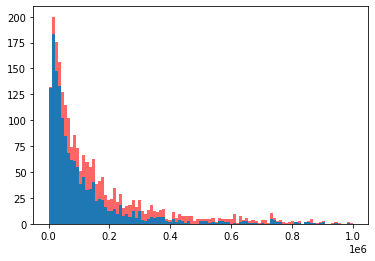

In [179]:
bins = np.linspace(0,1_000_000,100)
_,bins,_ = plt.hist(pctcf_downtss["distance"],bins=bins,alpha=0.6,color="red")
# plt.hist(xxx.drop_duplicates(subset=["chrom1_1","end1_1","end2_1"])["distance_1"],bins=bins)
plt.hist(xxx[pd.isna(xxx["start_2"])]["distance_1"],bins=bins);


In [186]:
yyy[(yyy["distance_1"]>100_000)&(yyy["strand2_1"]=="+")].rename(
    {"chrom1_1":"chrom1",
    "start1_1":"start1",
    "end1_1":"end1",
    "chrom2_1":"chrom2",
    "start2_1":"start2",
    "end2_1":"end2"},
    axis=1
    )[BEDPE_cols].astype(
    {"start1":np.int,
    "end1":np.int,
    "start2":np.int,
    "end2":np.int}
).reset_index(drop=True).to_csv("mctcf_ptss_nothingbetween.bedpe",index=False,sep="\t")



# "chrom1_1","start1_1","end1_1","type1_1","strand1_1","chrom2_1","start2_1","end2_1"
# "chrom1_1":"chrom1",
# "start1_1":"start1",
# "end1_1":"end1",
# "chrom2_1":"chrom2",
# "start2_1":"start2",
# "end2_1":"end2"